# Analysis of surface fields in SOGOS area

- variance at small scale
- surface spectra
- surface densities
- seasonal changes in above properties
- movies of surface fields


In [1]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
from xmitgcm import llcreader
from matplotlib import pyplot as plt
import cmocean.cm as cm

In [2]:
%matplotlib inline

In [3]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

In [4]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()


In [5]:
coords = (cat.LLC4320_grid.to_dask()).sel(face=1)

In [6]:
ds = xr.merge([ssh.sel(face=1), sst.sel(face=1), sss.sel(face=1), 
               u.sel(face=1), v.sel(face=1)])

In [7]:
import xgcm
grid = xgcm.Grid(coords.drop(['k', 'k_p1']), periodic=None)

In [8]:
from fastjmd95 import rho
ds['SSD'] = xr.apply_ufunc(rho, 
                        ds.SSS, ds.SST, 0, 
                        dask='parallelized', output_dtypes=[float,]).rename('SSD')

In [9]:
import gsw
ds['Spice'] = xr.apply_ufunc(gsw.spiciness0, 
                        ds.SSS, ds.SST,  
                        dask='parallelized', output_dtypes=[float,]).rename('Spice')

In [10]:
glid659 = xr.load_dataset('./glider_data/659_locs.nc')
glid660 = xr.load_dataset('./glider_data/660_locs.nc')

## Calc quantities with gradients

In [11]:
u_transport = ds.U * coords.dyG 
v_transport = ds.V * coords.dxG 

In [12]:
div_uv = (grid.diff(u_transport, 'X', boundary='extend') + grid.diff(v_transport, 'Y', boundary='extend')) / coords.rA

In [13]:
zeta = (-grid.diff(ds.U * coords.dxC, 'Y', boundary='extend') + grid.diff(ds.V * coords.dyC, 'X', boundary='extend'))/coords.rAz

In [14]:
strain1 = (grid.diff(ds.U * coords.dyG, 'X', boundary='extend') - grid.diff(ds.V * coords.dxG, 'Y',boundary='extend')) / coords.rA
strain2 = (grid.diff(ds.U * coords.dxC, 'Y', boundary='extend') + grid.diff(ds.V * coords.dyC, 'X', boundary='extend'))/coords.rAz
strain2 = grid.interp(grid.interp(strain2, 'X', boundary='extend'), 'Y', boundary='extend')

In [15]:
strain = (strain1**2 + strain2**2)**0.5

In [16]:
gradT = (grid.interp(grid.diff(ds.SST,'X',boundary='extend')/coords.dxC, 'X', boundary='extend')**2 +
         grid.interp(grid.diff(ds.SST,'Y',boundary='extend')/coords.dyC, 'Y', boundary='extend')**2)**0.5

In [17]:
gradS = (grid.interp(grid.diff(ds.SSS,'X',boundary='extend')/coords.dxC, 'X', boundary='extend')**2 +
         grid.interp(grid.diff(ds.SSS,'Y',boundary='extend')/coords.dyC, 'Y', boundary='extend')**2)**0.5

gradD = (grid.interp(grid.diff(ds.SSD,'X',boundary='extend')/coords.dxC, 'X', boundary='extend')**2 +
         grid.interp(grid.diff(ds.SSD,'Y',boundary='extend')/coords.dyC, 'Y', boundary='extend')**2)**0.5

In [18]:
KE = 0.5*(grid.interp(ds.U,'X',boundary='extend')**2 + grid.interp(ds.V,'Y',boundary='extend')**2) 

In [43]:
U = grid.interp(ds.U,'X',boundary='extend')
V = grid.interp(ds.V,'Y',boundary='extend')

### Select Area

SOGOS area   
Lat ~ -55 -> -48  
Lon ~ 28 -> 40

In [19]:
sel_XC = np.logical_and(coords.XC>25, coords.XC<40 ) 
sel_XG = np.logical_and(coords.XG>25, coords.XG<40 )
sel_YC = np.logical_and(coords.YC>-60, coords.YC<-45 )
sel_YG = np.logical_and(coords.YG>-60, coords.YG<-45 )

In [20]:
XC = coords.XC.where(sel_XC & sel_YC, drop=True)
YC = coords.YC.where(sel_XC & sel_YC, drop=True)
XCmean = XC.mean(['j'])
YCmean = YC.mean(['i'])

Xmax = XC.max(['j'])
Xmin = XC.min(['j'])
Ymax = YC.max(['i'])
Ymin = YC.min(['i'])

In [21]:
XG = coords.XG.where(sel_XG & sel_YG, drop=True)
YG = coords.YG.where(sel_XG & sel_YG, drop=True)
XGmean = XG.mean(['j_g'])
YGmean = YG.mean(['i_g'])

In [22]:
SSH_sogos = ds.Eta.where(sel_XC & sel_YC, drop=True)
SST_sogos = ds.SST.where(sel_XC & sel_YC, drop=True)
SSS_sogos = ds.SSS.where(sel_XC & sel_YC, drop=True)
SSD_sogos = ds.SSD.where(sel_XC & sel_YC, drop=True)

In [23]:
Spice_sogos = ds.Spice.where(sel_XC & sel_YC, drop=True)

In [24]:
zeta_sogos = zeta.where(sel_XG & sel_YG, drop=True)
div_sogos  = div_uv.where(sel_XC & sel_YC, drop=True)
strain_sogos = strain.where(sel_XC & sel_YC, drop=True)

In [25]:
gradD_sogos = gradD.where(sel_XC & sel_YC, drop=True)
gradT_sogos = gradT.where(sel_XC & sel_YC, drop=True)
gradS_sogos = gradS.where(sel_XC & sel_YC, drop=True)

In [26]:
KE_sogos = KE.where(sel_XC & sel_YC, drop=True)

In [44]:
U_sogos = U.where(sel_XC & sel_YC, drop=True)
V_sogos = V.where(sel_XC & sel_YC, drop=True)

### Seasonal Evolution of temperature, salinity, and height

In [83]:
SST_monthly= SST_sogos.isel(i=slice(0,-1,40), j=slice(0,-1,40), time=slice(0,-1,24*5)).groupby("time.month").mean(['time','i','j'])
SSD_monthly= SSD_sogos.isel(i=slice(0,-1,40), j=slice(0,-1,40), time=slice(0,-1,24*5)).groupby("time.month").mean(['time','i','j'])
SSS_monthly= SSS_sogos.isel(i=slice(0,-1,40), j=slice(0,-1,40), time=slice(0,-1,24*5)).groupby("time.month").mean(['time','i','j'])
Spice_monthly = Spice_sogos.isel(i=slice(0,-1,40), j=slice(0,-1,40), time=slice(0,-1,24*5)).groupby("time.month").mean(['time','i','j'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, 

In [85]:
SST_monthly.load();
SSS_monthly.load();
SSD_monthly.load();
Spice_monthly.load();

In [75]:
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes

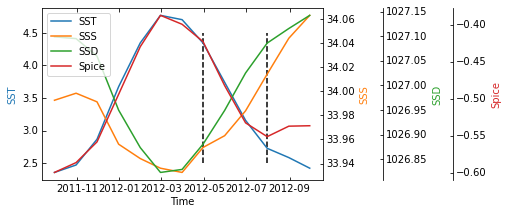

In [76]:
fig = plt.figure(figsize=(6,3))

host = HostAxes(fig, [0.15, 0.1, 0.65, 0.8])
par1 = ParasiteAxes(host, sharex=host)
par2 = ParasiteAxes(host, sharex=host)
par3 = ParasiteAxes(host, sharex=host)
host.parasites.append(par1)
host.parasites.append(par2)
host.parasites.append(par3)

host.set_ylabel("SST")
host.set_xlabel("Time")
host.axis["right"].set_visible(False)

par1.axis["right"].set_visible(True)
par1.set_ylabel("SSS")

par1.axis["right"].major_ticklabels.set_visible(True)
par1.axis["right"].label.set_visible(True)

par2.set_ylabel("SSD")
offset = (60, 0)
new_axisline = par2.get_grid_helper().new_fixed_axis
par2.axis["right2"] = new_axisline(loc="right", axes=par2, offset=offset)

par3.set_ylabel("Spice")
offset = (130, 0)
new_axisline = par3.get_grid_helper().new_fixed_axis
par3.axis["right3"] = new_axisline(loc="right", axes=par3, offset=offset)


fig.add_axes(host)

#host.set_xlim(0, 2)
#host.set_ylim(0, 2)

#host.set_xlabel("Distance")
#host.set_ylabel("Density")
#par1.set_ylabel("Temperature")

p1, = host.plot(SST_monthly.time, SST_monthly, label="SST")
host.vlines((SST_monthly.time[7].values,SST_monthly.time[10].values), 2.5,4.5, linestyles='dashed')

p2, = par1.plot(SSS_monthly.time, SSS_monthly, label="SSS")
p3, = par2.plot(SSD_monthly.time, SSD_monthly, label="SSD")
p4, = par3.plot(Spice_monthly.time, Spice_monthly, label="Spice")

#par1.set_ylim(0, 4)
#par2.set_ylim(1, 65)

host.legend(loc=2)

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right2"].label.set_color(p3.get_color())
par3.axis["right3"].label.set_color(p4.get_color())

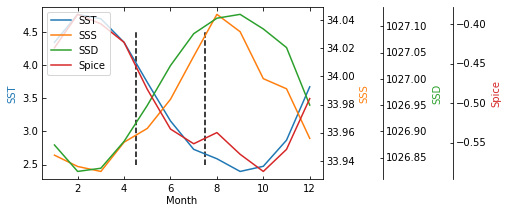

In [88]:
fig = plt.figure(figsize=(6,3))

host = HostAxes(fig, [0.15, 0.1, 0.65, 0.8])
par1 = ParasiteAxes(host, sharex=host)
par2 = ParasiteAxes(host, sharex=host)
par3 = ParasiteAxes(host, sharex=host)
host.parasites.append(par1)
host.parasites.append(par2)
host.parasites.append(par3)

host.set_ylabel("SST")
host.set_xlabel("Month")
host.axis["right"].set_visible(False)

par1.axis["right"].set_visible(True)
par1.set_ylabel("SSS")

par1.axis["right"].major_ticklabels.set_visible(True)
par1.axis["right"].label.set_visible(True)

par2.set_ylabel("SSD")
offset = (60, 0)
new_axisline = par2.get_grid_helper().new_fixed_axis
par2.axis["right2"] = new_axisline(loc="right", axes=par2, offset=offset)

par3.set_ylabel("Spice")
offset = (130, 0)
new_axisline = par3.get_grid_helper().new_fixed_axis
par3.axis["right3"] = new_axisline(loc="right", axes=par3, offset=offset)


fig.add_axes(host)

#host.set_xlim(0, 2)
#host.set_ylim(0, 2)

#host.set_xlabel("Distance")
#host.set_ylabel("Density")
#par1.set_ylabel("Temperature")

p1, = host.plot(SST_monthly.month, SST_monthly, label="SST")
host.vlines((4.5,7.5), 2.5,4.5, linestyles='dashed')

p2, = par1.plot(SSS_monthly.month, SSS_monthly, label="SSS")
p3, = par2.plot(SSD_monthly.month, SSD_monthly, label="SSD")
p4, = par3.plot(Spice_monthly.month, Spice_monthly, label="Spice")

#par1.set_ylim(0, 4)
#par2.set_ylim(1, 65)

host.legend(loc=2)

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right2"].label.set_color(p3.get_color())
par3.axis["right3"].label.set_color(p4.get_color())

### Seasonal Evolution of Gradient Quantities

In [27]:
# f=2*omega*sin(theta)
f = 2*(2*np.pi/24/3600)*np.sin(-55*np.pi/360)

In [104]:
strain_var = strain_sogos.isel(i=slice(0,-1,1), j=slice(0,-1,1), 
                               time=slice(0,-1,24*5)).var(['i','j'])

In [105]:
strain_var.load()

<xarray.DataArray (time: 76)>
array([2.9392713e-10, 3.9027379e-10, 2.8386188e-10, 2.6824651e-10,
       3.7340553e-10, 2.5138888e-10, 2.6190633e-10, 2.9275343e-10,
       3.1570899e-10, 3.1213496e-10, 2.3429861e-10, 2.4424809e-10,
       2.9191663e-10, 2.3165012e-10, 2.2393945e-10, 2.2186716e-10,
       2.3483135e-10, 2.9674702e-10, 2.6937247e-10, 2.6272221e-10,
       2.3923624e-10, 2.4958888e-10, 2.8822239e-10, 2.5465915e-10,
       2.0537504e-10, 2.7726096e-10, 2.7249039e-10, 2.9861139e-10,
       3.0537864e-10, 2.2410300e-10, 3.2454348e-10, 2.6466315e-10,
       2.3569868e-10, 2.6680813e-10, 2.5598709e-10, 2.0223619e-10,
       2.4879029e-10, 2.6925789e-10, 2.3640770e-10, 2.7312919e-10,
       2.4644542e-10, 2.0158716e-10, 2.9420069e-10, 2.2365138e-10,
       1.9323809e-10, 2.8635924e-10, 3.1659020e-10, 2.6874439e-10,
       3.1133940e-10, 2.4489855e-10, 3.0198241e-10, 3.0443084e-10,
       2.5832664e-10, 2.3817212e-10, 2.8315691e-10, 2.8512243e-10,
       3.5249331e-10, 3.8935438e-10, 3.8572928e-10, 3.7739512e-10,
       3.5695738e-10, 3.0582489e-10, 3.3020989e-10, 4.2388773e-10,
       3.3613756e-10, 3.4266417e-10, 3.6725950e-10, 3.7167605e-10,
       3.6532671e-10, 3.8713599e-10, 3.7319992e-10, 3.7539638e-10,
       4.7087939e-10, 3.9514944e-10, 4.8971172e-10, 3.6397219e-10],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-18 ... 2012-09-22
    PHrefC   float32 15.4017
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    drF      float32 1.14
    face     int64 1
    k        int64 1
    k_l      int64 1
    k_u      int64 1

In [106]:
zeta_var = zeta_sogos.isel(i_g=slice(0,-1,1), j_g=slice(0,-1,1), 
                               time=slice(0,-1,24*5)).var(['i_g','j_g'])
zeta_var.load()

<xarray.DataArray (time: 76)>
array([6.8110584e-10, 1.0237251e-09, 7.2880152e-10, 6.7640976e-10,
       1.0021863e-09, 6.5770889e-10, 6.6978423e-10, 7.6138856e-10,
       8.3595536e-10, 8.7392721e-10, 6.0796845e-10, 6.5375028e-10,
       7.5344997e-10, 5.7768651e-10, 5.7920685e-10, 5.3977595e-10,
       5.3842431e-10, 7.2414441e-10, 6.0550920e-10, 5.5557925e-10,
       5.3380933e-10, 5.2339238e-10, 5.7663024e-10, 5.6238197e-10,
       4.4275028e-10, 5.6325644e-10, 5.8854904e-10, 6.0037797e-10,
       5.8700067e-10, 5.1193394e-10, 6.9436218e-10, 5.2459748e-10,
       5.4449606e-10, 5.6138483e-10, 5.5094074e-10, 4.7101156e-10,
       5.1314958e-10, 5.7704908e-10, 5.7465394e-10, 6.0653466e-10,
       5.6977140e-10, 5.0713167e-10, 6.5990496e-10, 5.6419358e-10,
       4.7609960e-10, 6.8139638e-10, 7.7687828e-10, 6.7731631e-10,
       8.0377544e-10, 6.1254168e-10, 7.8676082e-10, 7.5985002e-10,
       6.7858358e-10, 6.3129341e-10, 7.3673079e-10, 7.2199141e-10,
       8.2656038e-10, 9.4850383e-10, 1.0771253e-09, 1.0046365e-09,
       9.0316443e-10, 7.7195778e-10, 8.3743829e-10, 1.1013347e-09,
       8.9836655e-10, 8.9252494e-10, 9.6059616e-10, 9.8482245e-10,
       9.0524616e-10, 9.6166597e-10, 9.7035369e-10, 9.7862629e-10,
       1.2190088e-09, 9.4201258e-10, 1.1780326e-09, 9.2356067e-10],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-18 ... 2012-09-22
    PHrefC   float32 15.4017
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    drF      float32 1.14
    face     int64 1
    k        int64 1
    k_l      int64 1
    k_u      int64 1

In [68]:
gradD_var = gradD_sogos.isel(i=slice(0,-1,1), j=slice(0,-1,1), 
                               time=slice(0,-1,24*5)).var(['i','j'])
gradD_var.load();

<xarray.DataArray (time: 76)>
array([1.28823195e-11, 1.59039452e-11, 1.30973176e-11, 1.03704923e-11,
       1.58297802e-11, 1.09704693e-11, 1.13484225e-11, 1.41552885e-11,
       1.72352186e-11, 2.01980869e-11, 1.45555368e-11, 1.63059291e-11,
       1.78389350e-11, 1.57644170e-11, 1.67470868e-11, 1.64872903e-11,
       1.68711636e-11, 2.31704912e-11, 2.13858845e-11, 1.77616707e-11,
       2.23070178e-11, 2.80369286e-11, 3.16123766e-11, 3.68175832e-11,
       2.23560906e-11, 3.48539722e-11, 3.62784356e-11, 3.73670612e-11,
       3.32041697e-11, 3.82911909e-11, 4.57120457e-11, 3.12509100e-11,
       4.06611571e-11, 3.98158977e-11, 3.71683544e-11, 3.08979768e-11,
       3.48185268e-11, 3.82403530e-11, 3.87587859e-11, 3.33891552e-11,
       3.43965618e-11, 2.76428604e-11, 2.97239253e-11, 2.06604073e-11,
       1.91890500e-11, 2.55403296e-11, 2.89592774e-11, 2.41897603e-11,
       2.17448734e-11, 1.99786676e-11, 2.38670932e-11, 2.11306026e-11,
       1.71447815e-11, 1.49620587e-11, 1.83585877e-11, 1.74480341e-11,
       1.79174100e-11, 1.83735083e-11, 2.06455638e-11, 1.94258167e-11,
       1.72438204e-11, 1.30755001e-11, 1.43384653e-11, 1.71640314e-11,
       1.51161981e-11, 1.61158669e-11, 1.67340392e-11, 2.00646943e-11,
       1.76030255e-11, 1.70724347e-11, 1.53023387e-11, 1.44004010e-11,
       1.64553236e-11, 1.43343221e-11, 2.37140221e-11, 1.53203151e-11])
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-18 ... 2012-09-22
    PHrefC   float32 15.4017
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    drF      float32 1.14
    face     int64 1
    k        int64 1
    k_l      int64 1
    k_u      int64 1

In [107]:
(strain_var**0.5/(-f)).plot(label='Strain')
(zeta_var**0.5/(-f)).plot(label='Vorticity')
#(div_var**0.5/(-f)).plot(label='Divergence')
plt.legend()
plt.title('Spatial RMS at 5 day intervals')
plt.grid()

In [69]:
gradD_var.plot(label=r'\nabla \rho')
#(div_var**0.5/(-f)).plot(label='Divergence')
plt.legend()
plt.title('Spatial RMS at 5 day intervals')
plt.grid()

In [39]:
div_var = div_sogos.isel(i=slice(0,-1,10), j=slice(0,-1,10), 
                               time=slice(0,-1,24*5)).var(['i','j'])

In [40]:

div_var.load();

<xarray.DataArray (time: 76)>
array([1.3826461e-10, 2.2596780e-10, 1.9508833e-10, 2.0004812e-10,
       2.1640081e-10, 1.5745201e-10, 1.8632777e-10, 1.9219266e-10,
       1.8899191e-10, 2.1734907e-10, 1.7912201e-10, 1.8190718e-10,
       1.8631767e-10, 1.7143496e-10, 1.6579493e-10, 1.7808491e-10,
       1.8556026e-10, 2.1943536e-10, 2.1891118e-10, 2.6565539e-10,
       2.8834721e-10, 2.6109842e-10, 2.7714450e-10, 2.8308292e-10,
       2.0072488e-10, 2.3571942e-10, 2.1786953e-10, 2.1817409e-10,
       2.6393593e-10, 2.0867640e-10, 2.5864252e-10, 2.2296993e-10,
       2.3464372e-10, 2.6410535e-10, 2.5243460e-10, 2.0195505e-10,
       2.3135843e-10, 2.5544863e-10, 2.3150051e-10, 2.4595143e-10,
       2.5031474e-10, 2.0792590e-10, 2.5850846e-10, 2.0612127e-10,
       1.9027152e-10, 2.5824792e-10, 2.3947419e-10, 2.0344898e-10,
       2.2053115e-10, 2.0628410e-10, 2.4662808e-10, 2.5566591e-10,
       1.9281049e-10, 1.5738343e-10, 2.1336316e-10, 2.3112577e-10,
       2.4465918e-10, 2.2732242e-10, 2.2837643e-10, 2.1641067e-10,
       2.0806143e-10, 1.8671761e-10, 1.9198834e-10, 2.5220917e-10,
       2.1045692e-10, 2.0388032e-10, 2.1301229e-10, 2.0877303e-10,
       2.1117387e-10, 2.6217314e-10, 2.6116032e-10, 2.4151670e-10,
       2.6743774e-10, 2.1238716e-10, 2.4864996e-10, 2.2491688e-10],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-18 ... 2012-09-22
    PHrefC   float32 15.4017
    Z        float32 -1.57
    Zl       float32 -1.0
    Zu       float32 -2.14
    drF      float32 1.14
    face     int64 1
    k        int64 1
    k_l      int64 1
    k_u      int64 1

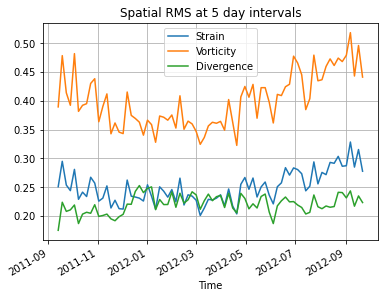

In [45]:
(strain_var**0.5/(-f)).plot(label='Strain')
(zeta_var**0.5/(-f)).plot(label='Vorticity')
(div_var**0.5/(-f)).plot(label='Divergence')
plt.legend()
plt.title('Spatial RMS at 5 day intervals')
plt.grid()

In [108]:
strain_var_time = strain_sogos.isel(i=slice(0,-1,5), j=slice(0,-1,5), 
                               time=slice(0,-1,5*24)).var(['time'])

In [109]:
strain_var_time.load();

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [123]:
SV_coarse = strain_var_time.coarsen(i=5, j=5, boundary='trim').mean();
XC_coarse = XC.isel(i=slice(0,-1,5), j=slice(0,-1,5)).coarsen(i=5, j=5, boundary='trim').mean()
YC_coarse = YC.isel(i=slice(0,-1,5), j=slice(0,-1,5)).coarsen(i=5, j=5, boundary='trim').mean()

Text(0.5, 1.0, 'Strain Variance')

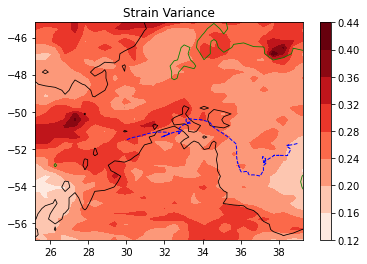

In [125]:
plt.contourf(XC_coarse, YC_coarse, 
               SV_coarse**0.5/(-f), cmap='Reds', vmax=0.4 )
plt.colorbar()

plt.plot(glid659.longitude, glid659.latitude, '--', linewidth=1, color='b')

plt.contour(XC_coarse, YC_coarse, 
               SV_coarse.Depth, levels=[3000,  5000], linewidths=0.8,
           colors=['g','k'])

plt.title('Strain Variance')

## Histograms of gradient quantities

In [36]:
bins = np.linspace(-2, 4, 20)

In [45]:
zeta_sogos_3day = zeta_sogos.isel(time=slice(0,-1,24*3))

In [46]:
vort_hist_SON = np.histogram(zeta_sogos_3day.isel(i_g=slice(0,-1,5), j_g=slice(0,-1,5), 
                            time=zeta_sogos_3day.groupby("time.season").groups['SON'])/f, bins=bins);

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


In [47]:
vort_hist_DJF = np.histogram(zeta_sogos_3day.isel(i_g=slice(0,-1,5), j_g=slice(0,-1,5), 
                            time=zeta_sogos_3day.groupby("time.season").groups['DJF'])/f, bins=bins);
vort_hist_MAM = np.histogram(zeta_sogos_3day.isel(i_g=slice(0,-1,5), j_g=slice(0,-1,5), 
                            time=zeta_sogos_3day.groupby("time.season").groups['MAM'])/f, bins=bins);
vort_hist_JJA = np.histogram(zeta_sogos_3day.isel(i_g=slice(0,-1,5), j_g=slice(0,-1,5), 
                            time=zeta_sogos_3day.groupby("time.season").groups['JJA'])/f, bins=bins);


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, 

Text(0, 0.5, 'DF')

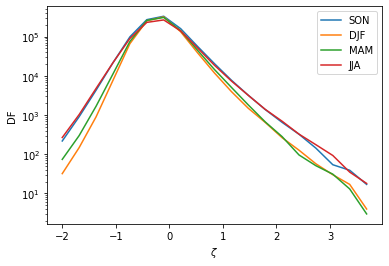

In [54]:
plt.plot(bins[0:-1], vort_hist_SON[0], label='SON')
plt.plot(bins[0:-1], vort_hist_DJF[0], label='DJF')
plt.plot(bins[0:-1], vort_hist_MAM[0], label='MAM')
plt.plot(bins[0:-1], vort_hist_JJA[0], label='JJA')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\zeta/f$')
plt.ylabel('DF')

In [50]:
strainbins = np.linspace(0, 4, 20)

In [49]:
strain_sogos_3day = strain_sogos.isel(time=slice(0,-1,24*3))

In [56]:
strain_hist_SON = np.histogram(strain_sogos_3day.isel(i=slice(0,-1,5), j=slice(0,-1,5), 
                            time=strain_sogos_3day.groupby("time.season").groups['SON'])/(-f), bins=strainbins);

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


In [60]:
strain_hist_DJF = np.histogram(strain_sogos_3day.isel(i=slice(0,-1,5), j=slice(0,-1,5), 
                            time=strain_sogos_3day.groupby("time.season").groups['DJF'])/(-f), bins=strainbins);
strain_hist_MAM = np.histogram(strain_sogos_3day.isel(i=slice(0,-1,5), j=slice(0,-1,5), 
                            time=strain_sogos_3day.groupby("time.season").groups['MAM'])/(-f), bins=strainbins);
strain_hist_JJA = np.histogram(strain_sogos_3day.isel(i=slice(0,-1,5), j=slice(0,-1,5), 
                            time=strain_sogos_3day.groupby("time.season").groups['JJA'])/(-f), bins=strainbins);


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, 

Text(0, 0.5, 'DF')

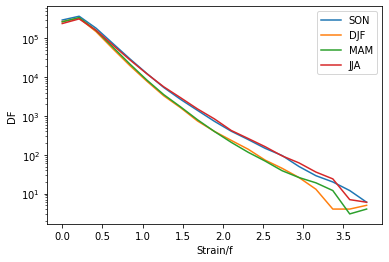

In [61]:
plt.plot(strainbins[0:-1], strain_hist_SON[0], label='SON')
plt.plot(strainbins[0:-1], strain_hist_DJF[0], label='DJF')
plt.plot(strainbins[0:-1], strain_hist_MAM[0], label='MAM')
plt.plot(strainbins[0:-1], strain_hist_JJA[0], label='JJA')
plt.yscale('log')
plt.legend()
plt.xlabel('Strain/f')
plt.ylabel('DF')

In [62]:
gradDbins = np.linspace(0, 1e-4, 20)

In [63]:
gradD_sogos_3day = gradD_sogos.isel(time=slice(0,-1,24*3))

In [64]:
gradD_hist_SON = np.histogram(gradD_sogos_3day.isel(i=slice(0,-1,5), j=slice(0,-1,5), 
                        time=gradD_sogos_3day.groupby("time.season").groups['SON']), bins=gradDbins);

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


In [66]:
gradD_hist_DJF = np.histogram(gradD_sogos_3day.isel(i=slice(0,-1,5), j=slice(0,-1,5), 
                        time=gradD_sogos_3day.groupby("time.season").groups['DJF']), bins=gradDbins);
gradD_hist_MAM = np.histogram(gradD_sogos_3day.isel(i=slice(0,-1,5), j=slice(0,-1,5), 
                        time=gradD_sogos_3day.groupby("time.season").groups['MAM']), bins=gradDbins);
gradD_hist_JJA = np.histogram(gradD_sogos_3day.isel(i=slice(0,-1,5), j=slice(0,-1,5), 
                        time=gradD_sogos_3day.groupby("time.season").groups['JJA']), bins=gradDbins);

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, 

Text(0, 0.5, 'DF')

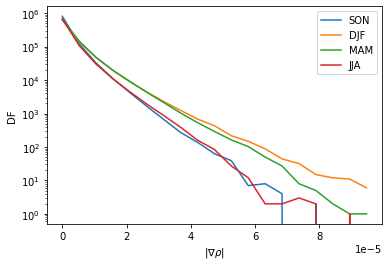

In [67]:
plt.plot(gradDbins[0:-1], gradD_hist_SON[0], label='SON')
plt.plot(gradDbins[0:-1], gradD_hist_DJF[0], label='DJF')
plt.plot(gradDbins[0:-1], gradD_hist_MAM[0], label='MAM')
plt.plot(gradDbins[0:-1], gradD_hist_JJA[0], label='JJA')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$|\nabla \rho|$')
plt.ylabel('DF')

## Seasonal Maps

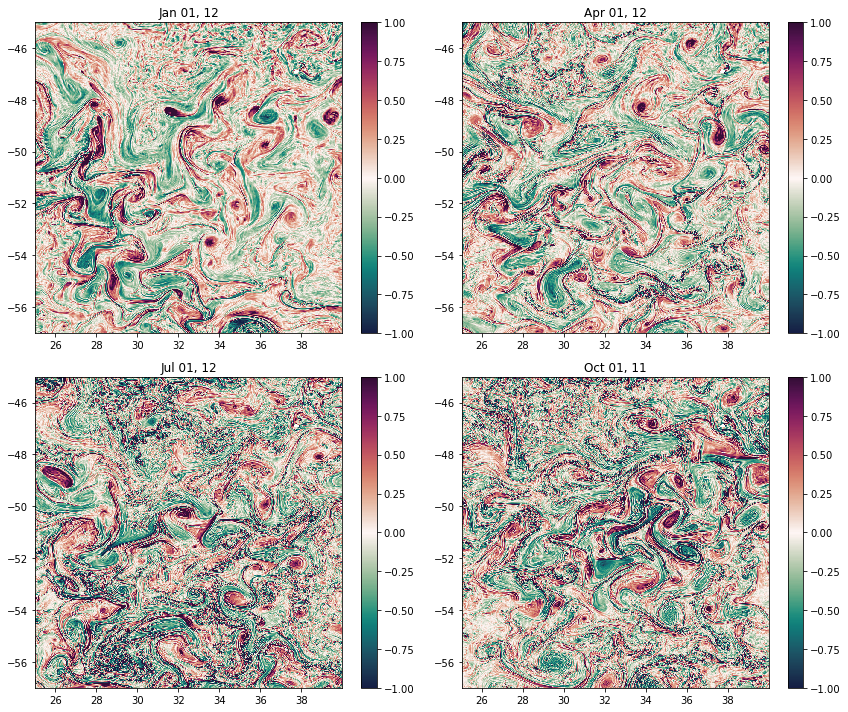

In [33]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.pcolormesh(XG, YG, 
               zeta_sogos.sel(time='2012-01-01T00:00:00')/f, vmin=-1, vmax=1, cmap=cm.curl)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-01-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(222)
plt.pcolormesh(XG, YG, 
               zeta_sogos.sel(time='2012-04-01T00:00:00')/f, vmin=-1, vmax=1, cmap=cm.curl)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-04-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(223)
plt.pcolormesh(XG, YG, 
               zeta_sogos.sel(time='2012-07-01T00:00:00')/f, vmin=-1, vmax=1, cmap=cm.curl)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-07-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(224)
plt.pcolormesh(XG, YG, 
               zeta_sogos.sel(time='2011-10-01T00:00:00')/f, vmin=-1, vmax=1, cmap=cm.curl)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2011-10-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.tight_layout()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


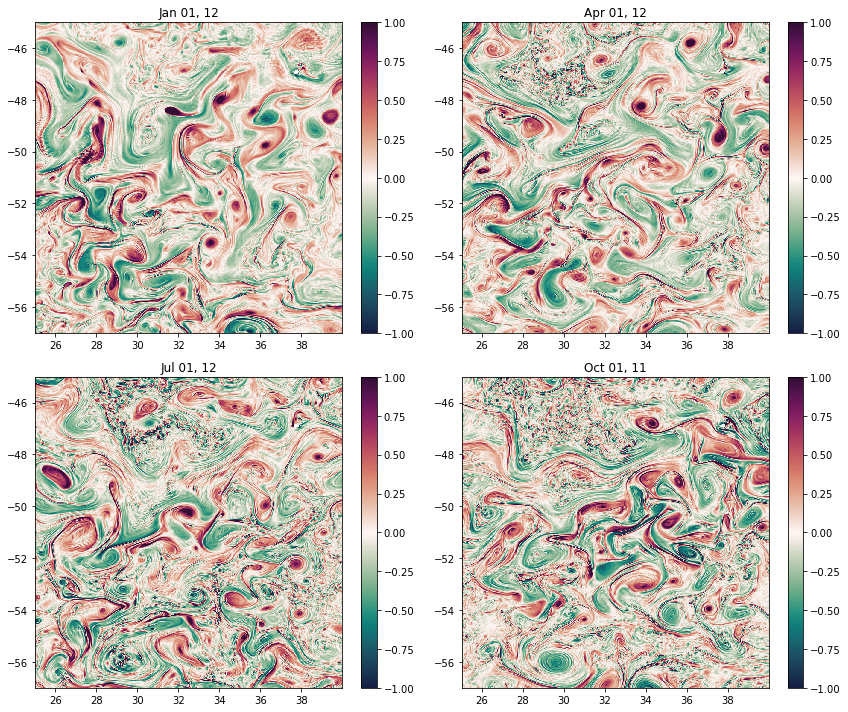

In [34]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.pcolormesh(XG, YG, 
               zeta_sogos.sel(time='2012-01-01').mean('time')/f, vmin=-1, vmax=1, cmap=cm.curl)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-01-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(222)
plt.pcolormesh(XG, YG, 
               zeta_sogos.sel(time='2012-04-01').mean('time')/f, vmin=-1, vmax=1, cmap=cm.curl)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-04-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(223)
plt.pcolormesh(XG, YG, 
               zeta_sogos.sel(time='2012-07-01T').mean('time')/f, vmin=-1, vmax=1, cmap=cm.curl)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-07-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(224)
plt.pcolormesh(XG, YG, 
               zeta_sogos.sel(time='2011-10-01T').mean('time')/f, vmin=-1, vmax=1, cmap=cm.curl)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2011-10-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.tight_layout()

In [36]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.pcolormesh(XC, YC, 
               strain_sogos.sel(time='2012-01-01T00:00:00')/-f, vmin=0, vmax=1, cmap=cm.amp)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-01-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(222)
plt.pcolormesh(XC, YC, 
               strain_sogos.sel(time='2012-04-01T00:00:00')/-f, vmin=0, vmax=1, cmap=cm.amp)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-04-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(223)
plt.pcolormesh(XC, YC, 
               strain_sogos.sel(time='2012-07-01T00:00:00')/-f, vmin=0, vmax=1, cmap=cm.amp)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-07-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(224)
plt.pcolormesh(XC, YC, 
               strain_sogos.sel(time='2011-10-01T00:00:00')/-f, vmin=0, vmax=1, cmap=cm.amp)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2011-10-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.tight_layout()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


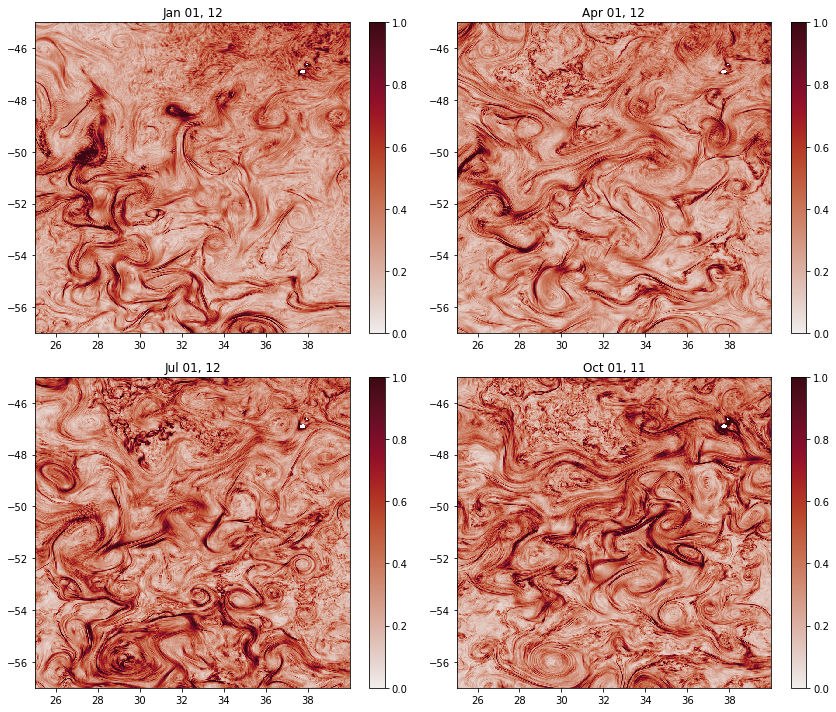

In [37]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.pcolormesh(XC, YC, 
               strain_sogos.sel(time='2012-01-01').mean('time')/-f, vmin=0, vmax=1, cmap=cm.amp)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-01-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(222)
plt.pcolormesh(XC, YC, 
               strain_sogos.sel(time='2012-04-01').mean('time')/-f, vmin=0, vmax=1, cmap=cm.amp)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-04-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(223)
plt.pcolormesh(XC, YC, 
               strain_sogos.sel(time='2012-07-01').mean('time')/-f, vmin=0, vmax=1, cmap=cm.amp)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-07-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(224)
plt.pcolormesh(XC, YC, 
               strain_sogos.sel(time='2011-10-01').mean('time')/-f, vmin=0, vmax=1, cmap=cm.amp)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2011-10-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.tight_layout()

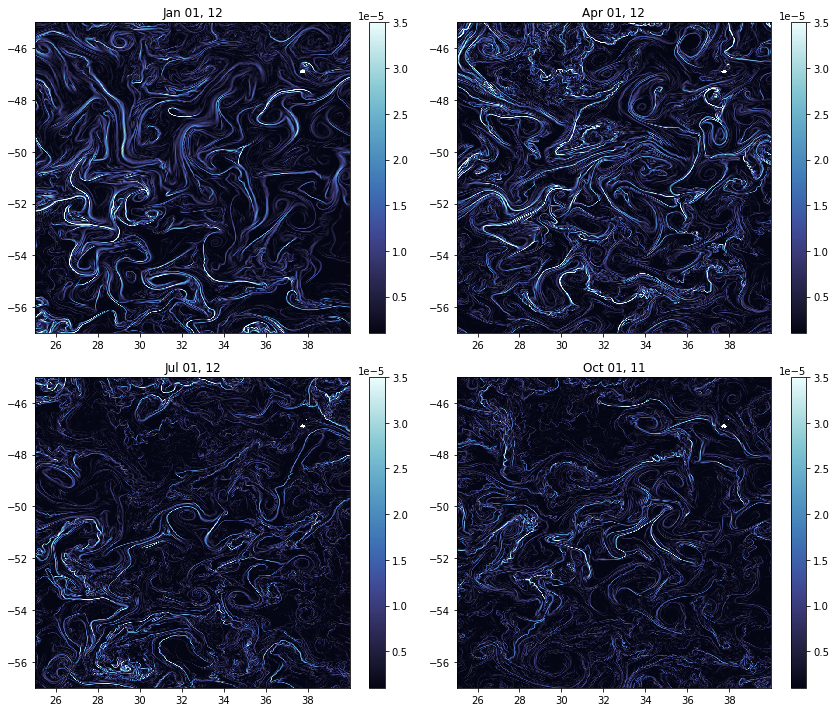

In [38]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.pcolormesh(XC, YC, 
               gradD_sogos.sel(time='2012-01-01T00:00:00'), vmin=0.1e-5, vmax=3.5e-5, cmap=cm.ice)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-01-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(222)
plt.pcolormesh(XC, YC, 
               gradD_sogos.sel(time='2012-04-01T00:00:00'), vmin=0.1e-5, vmax=3.5e-5, cmap=cm.ice)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-04-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(223)
plt.pcolormesh(XC, YC, 
               gradD_sogos.sel(time='2012-07-01T00:00:00'), vmin=0.1e-5, vmax=3.5e-5, cmap=cm.ice)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2012-07-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.subplot(224)
plt.pcolormesh(XC, YC, 
               gradD_sogos.sel(time='2011-10-01T00:00:00'), vmin=0.1e-5, vmax=3.5e-5, cmap=cm.ice)
plt.colorbar()
plt.title(zeta_sogos.time.sel(time='2011-10-01T00:00:00').dt.strftime("%b %d, %y").values)

plt.tight_layout()

## Horizontal Spectra

In [40]:
# density
SSD_k_ps = xrft.power_spectrum(SSD_sogos,
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('SSD_psd')

In [42]:
# spice
Spice_k_ps = xrft.power_spectrum(Spice_sogos,
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('Spice_psd')

In [45]:
# velocity
U_k_ps = xrft.power_spectrum(U_sogos,
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('U_psd')
V_k_ps = xrft.power_spectrum(V_sogos,
                               dim=['i'],
                               window=True, 
                               detrend='constant').rename('V_psd')


In [46]:
EKE_k_ps = (0.5*(U_k_ps + V_k_ps)).rename('EKE_psd')

In [48]:
SSD_k_ps_3day = SSD_k_ps.isel(time=slice(0,-1,24*5))

SSD_k_SON = SSD_k_ps_3day.isel(j=slice(0,-1,10),
                               time=SSD_k_ps_3day.groupby("time.season").groups['SON']).mean(['j','time'])
SSD_k_DJF = SSD_k_ps_3day.isel(j=slice(0,-1,10),
                               time=SSD_k_ps_3day.groupby("time.season").groups['DJF']).mean(['j','time'])
SSD_k_MAM = SSD_k_ps_3day.isel(j=slice(0,-1,10),
                               time=SSD_k_ps_3day.groupby("time.season").groups['MAM']).mean(['j','time'])
SSD_k_JJA = SSD_k_ps_3day.isel(j=slice(0,-1,10),
                               time=SSD_k_ps_3day.groupby("time.season").groups['JJA']).mean(['j','time'])

In [50]:
SSD_k_SON.load();
SSD_k_DJF.load();
SSD_k_MAM.load();
SSD_k_JJA.load();

In [60]:
Spice_k_ps_3day = Spice_k_ps.isel(time=slice(0,-1,24*5))

Spice_k_SON = Spice_k_ps_3day.isel(j=slice(0,-1,10),
                               time=Spice_k_ps_3day.groupby("time.season").groups['SON']).mean(['j','time'])
Spice_k_DJF = Spice_k_ps_3day.isel(j=slice(0,-1,10),
                               time=Spice_k_ps_3day.groupby("time.season").groups['DJF']).mean(['j','time'])
Spice_k_MAM = Spice_k_ps_3day.isel(j=slice(0,-1,10),
                               time=Spice_k_ps_3day.groupby("time.season").groups['MAM']).mean(['j','time'])
Spice_k_JJA = Spice_k_ps_3day.isel(j=slice(0,-1,10),
                               time=Spice_k_ps_3day.groupby("time.season").groups['JJA']).mean(['j','time'])

In [61]:
Spice_k_SON.load();
Spice_k_DJF.load();
Spice_k_MAM.load();
Spice_k_JJA.load();

In [62]:
EKE_k_ps_3day = EKE_k_ps.isel(time=slice(0,-1,24*5))

EKE_k_SON = EKE_k_ps_3day.isel(j=slice(0,-1,10),
                               time=EKE_k_ps_3day.groupby("time.season").groups['SON']).mean(['j','time'])
EKE_k_DJF = EKE_k_ps_3day.isel(j=slice(0,-1,10),
                               time=EKE_k_ps_3day.groupby("time.season").groups['DJF']).mean(['j','time'])
EKE_k_MAM = EKE_k_ps_3day.isel(j=slice(0,-1,10),
                                time=EKE_k_ps_3day.groupby("time.season").groups['MAM']).mean(['j','time'])
EKE_k_JJA = EKE_k_ps_3day.isel(j=slice(0,-1,10),
                               time=EKE_k_ps_3day.groupby("time.season").groups['JJA']).mean(['j','time'])

In [63]:
EKE_k_SON.load();
EKE_k_DJF.load();
EKE_k_MAM.load();
EKE_k_JJA.load();

In [55]:
dx = (110*(XC.isel(i=1) - XC.isel(i=0))*np.cos(YC.isel(i=0)*np.pi/180))
dx_mean = dx.mean('j')

In [54]:
dx.plot() # dx changes a little bit through the domain.

In [76]:
k = SSD_k_SON.freq_i/dx_mean

plt.plot(k, SSD_k_SON, label='SON')
plt.plot(k, SSD_k_DJF, label='DJF')
plt.plot(k, SSD_k_MAM, label='MAM')
plt.plot(k, SSD_k_JJA, label='JJA')

plt.plot(k, 5e-4*k**-1, '--',linewidth=1,color='gray', label='-1')
plt.plot(k, 5e-7*k**-2, '--',linewidth=1,color='gray', label='-2')
plt.plot(k, 5e-10*k**-3, '--',linewidth=1,color='gray', label='-3')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Density')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Density')

In [103]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(k, Spice_k_SON, label='SON')
plt.plot(k, Spice_k_DJF, label='DJF')
plt.plot(k, Spice_k_MAM, label='MAM')
plt.plot(k, Spice_k_JJA, label='JJA')

plt.plot(k, 5e-6*k**-2, '--',linewidth=1,color='gray', label='-2')
plt.plot(k, 5e-9*k**-3, '--',linewidth=1,color='gray', label='-3')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Spice')

plt.subplot(122)
plt.plot(k, Spice_k_SON, label='SON')
plt.plot(k, Spice_k_DJF, label='DJF')
plt.plot(k, Spice_k_MAM, label='MAM')
plt.plot(k, Spice_k_JJA, label='JJA')

plt.xlim([1/50, 1/3])
plt.ylim([1e-6, 1e-2])

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Spice')
plt.tight_layout()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'EKE')

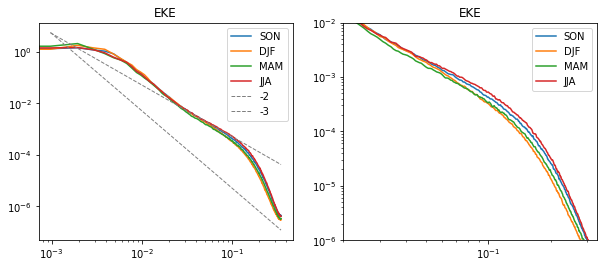

In [104]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(k, EKE_k_SON, label='SON')
plt.plot(k, EKE_k_DJF, label='DJF')
plt.plot(k, EKE_k_MAM, label='MAM')
plt.plot(k, EKE_k_JJA, label='JJA')

plt.plot(k, 5e-6*k**-2, '--',linewidth=1,color='gray', label='-2')
plt.plot(k, 5e-9*k**-3, '--',linewidth=1,color='gray', label='-3')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('EKE')

plt.subplot(122)
plt.plot(k, EKE_k_SON, label='SON')
plt.plot(k, EKE_k_DJF, label='DJF')
plt.plot(k, EKE_k_MAM, label='MAM')
plt.plot(k, EKE_k_JJA, label='JJA')

plt.xlim([1/50, 1/3])
plt.ylim([1e-6, 1e-2])

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('EKE')

In [105]:
plt.plot(k, EKE_k_JJA/EKE_k_DJF, label='EKE')
plt.plot(k, Spice_k_JJA/Spice_k_DJF, label='Spice')
plt.plot(k, SSD_k_JJA/EKE_k_DJF, label='Density')

plt.xscale('log')
plt.legend()
plt.hlines(1, 0, 1/3, linewidth=1.)
plt.ylim([0,4])
plt.title('Winter /Summer (JJA/DJF) Ratios')

# months chosen for strong cooling and warming periods

Text(0.5, 1.0, 'Winter /Summer (JJA/DJF) Ratios')